<a href="https://colab.research.google.com/github/rajaswa/Summer-Internship-IIT-Bombay-2019/blob/master/topic_identification_ads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading Data from Google Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

with open('/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/My Drive/foo.txt'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
Hello Google Drive!

# Installing dependencies

In [2]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 4.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [3]:
import nltk
nltk.download('stopwords')

!python3 -m spacy download en

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



# Imports

In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [0]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Data loading & preprocessing

In [6]:
#loading as pandas dataframe

df = pd.read_excel('/gdrive/My Drive/ADS.xlsx')
df = df.dropna()
print(len(df))
df[:5]

17


,How likely are you to recommend this course to someone else?,Unnamed: 1,9. What was the best part of this course and why?,10. What would have improved your experience in this course?
0,Too costly for the same content available at v...,Course material should include the slides and ...,Assignment 2 because it challenged me.,A more intensive load.
1,Need more time to complete all assignments,There is a lots of practical matters that need...,Great quality video lectures. Instructors wer...,I am not sure. I think I under estimated amou...
2,it is too pricy for a beginner course compared...,Quizzes should have been more structured. New ...,Got to learn using Videos and practice using d...,More practice questions for each topic not as ...
3,"Terrible user experience, poor video lessons, ...","as I explained in details by email, videos sho...",Quality content in the videos,Lower the price or more value to the certificate
4,Poor presentations from content to the way the...,"While the content was useful, and I did learn ...",It is not my intention to be a high level prog...,Maybe a little more instruction and facilitati...


In [7]:
df.columns

Index(['How likely are you to recommend this course to someone else?',
       'Unnamed: 1', '9. What was the best part of this course and why?',
       '10. What would have improved your experience in this course?'],
      dtype='object')

In [8]:
#text preprocessing
data = []

for col in df.columns:
  # Convert to list
  text = df[col].values.tolist()

  # Remove Emails
  text = [re.sub('\S*@\S*\s?', '', sent) for sent in text]

  # Remove new line characters
  text = [re.sub('\s+', ' ', sent) for sent in text]

  # Remove distracting single quotes
  text = [re.sub("\'", "", sent) for sent in text]
  
  for i in range(len(text)):    
    data.append(text[i])
pprint(data)

['Too costly for the same content available at very low prices',
 'Need more time to complete all assignments',
 'it is too pricy for a beginner course compared to courses in market',
 'Terrible user experience, poor video lessons, messy evaluation process',
 'Poor presentations from content to the way the get delivered. Very poor '
 'linage from theory to Python and related. Very poor linage from theory to '
 'life. Bad timing for live webinars for folks in west coast who work :-( The '
 'training system was often broken, your guys did not have a clue how to fix, '
 'Clearly you are making money from selling high flying agenda but nit '
 'dekivering in the promise. Heard this from others and the Columbia brand is '
 'wracked ',
 'There was a lack of fit between the lectures and the assignments. Often, '
 'code wouldnt work because of outdated links, etc. I feel like the staff '
 'should have been more coordinated and more attention should have been paid '
 'to the content so that ever

In [9]:
#tokenizing text

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['too', 'costly', 'for', 'the', 'same', 'content', 'available', 'at', 'very', 'low', 'prices']]


In [10]:
#building bigram & trigram models for frequently occuring n-grams

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['too', 'costly', 'for', 'the', 'same', 'content', 'available', 'at', 'very', 'low', 'prices']


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [0]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['costly', 'content', 'available', 'low', 'price']]


In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [14]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('available', 1), ('content', 1), ('costly', 1), ('low', 1), ('price', 1)]]

# LDA Model

In [0]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=0,
                                           chunksize=4,
                                           passes=8,
                                           alpha='auto',
                                           per_word_topics=True)

In [16]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.021*"much" + 0.012*"different" + 0.012*"hw" + 0.012*"alternative" + '
  '0.012*"wrong" + 0.012*"disorganization" + 0.012*"logistic" + 0.012*"mark" + '
  '0.012*"correct" + 0.012*"bad"'),
 (1,
  '0.020*"completely" + 0.019*"blog" + 0.017*"mobile" + 0.017*"app" + '
  '0.011*"team" + 0.011*"timely" + 0.011*"small" + 0.011*"view" + '
  '0.011*"quickly" + 0.011*"fashion"'),
 (2,
  '0.021*"often" + 0.019*"lecture" + 0.016*"poor" + 0.016*"cover" + '
  '0.015*"work" + 0.015*"content" + 0.015*"would" + 0.014*"material" + '
  '0.011*"theory" + 0.011*"linage"'),
 (3,
  '0.012*"consider" + 0.012*"continue" + 0.012*"foolish" + 0.012*"denie" + '
  '0.012*"righ" + 0.012*"meet" + 0.012*"strongly" + 0.012*"costly" + '
  '0.012*"available" + 0.012*"set"'),
 (4,
  '0.036*"course" + 0.026*"video" + 0.018*"assignment" + 0.017*"time" + '
  '0.015*"material" + 0.015*"learn" + 0.013*"learning" + 0.012*"work" + '
  '0.011*"question" + 0.010*"good"')]


In [17]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.259744472206639

Coherence Score:  0.6077529391127386


In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.079175 -0.064663       1        1  74.158707
2     -0.108412 -0.034581       2        1  16.420511
1      0.022743  0.047365       3        1   4.026828
0     -0.006114  0.019266       4        1   3.112239
3      0.012608  0.032613       5        1   2.281719, topic_info=    Category       Freq          Term      Total  loglift  logprob
99   Default   3.000000          much   3.000000  30.0000  30.0000
7    Default   4.000000          need   4.000000  29.0000  29.0000
73   Default   7.000000       lecture   7.000000  28.0000  28.0000
1    Default   6.000000       content   6.000000  27.0000  27.0000
18   Default   6.000000          poor   6.000000  26.0000  26.0000
116  Default   8.000000         learn   8.000000  25.0000  25.0000
121  Default   3.000000     practical   3.000000  24.0000  24.0000
122  Default   6.000000      question   6.000000  23.0000  23.0000
108  Default   4.000000        answer   4.000000  22.0000  22.0000
81   Default   7.000000         would   7.000000  21.0000  21.0000
153  Default   3.000000         topic   3.000000  20.0000  20.0000
92   Default   3.000000         cover   3.000000  19.0000  19.0000
22   Default  15.000000         video  15.000000  18.0000  18.0000
231  Default   3.000000       support   3.000000  17.0000  17.0000
45   Default   2.000000         often   2.000000  16.0000  16.0000
35   Default   4.000000           get   4.000000  15.0000  15.0000
152  Default   2.000000       quality   2.000000  14.0000  14.0000
109  Default   1.000000          blog   1.000000  13.0000  13.0000
56   Default   3.000000           way   3.000000  12.0000  12.0000
186  Default   1.000000           set   1.000000  11.0000  11.0000
182  Default   1.000000           lot   1.000000  10.0000  10.0000
183  Default   1.000000        matter   1.000000   9.0000   9.0000
3    Default   1.000000           low   1.000000   8.0000   8.0000
4    Default   1.000000         price   1.000000   7.0000   7.0000
149  Default   1.000000   instruction   1.000000   6.0000   6.0000
146  Default   1.000000     effective   1.000000   5.0000   5.0000
147  Default   1.000000     expensive   1.000000   4.0000   4.0000
85   Default   1.000000           due   1.000000   3.0000   3.0000
83   Default   1.000000      teaching   1.000000   2.0000   2.0000
59   Default   8.000000          work   8.000000   1.0000   1.0000
..       ...        ...           ...        ...      ...      ...
186   Topic5   0.201329           set   1.514222   1.7625  -4.4360
182   Topic5   0.201057           lot   1.515278   1.7605  -4.4373
183   Topic5   0.200951        matter   1.515688   1.7597  -4.4378
3     Topic5   0.180048           low   1.596634   1.5978  -4.5477
4     Topic5   0.180029         price   1.596685   1.5977  -4.5478
227   Topic5   0.044810        nearly   0.713584   1.0124  -5.9385
237   Topic5   0.043442  unresponsive   0.713401   0.9816  -5.9695
228   Topic5   0.043435          post   0.715060   0.9791  -5.9696
226   Topic5   0.043252       monitor   0.713765   0.9767  -5.9739
234   Topic5   0.043221         thing   0.714937   0.9744  -5.9746
236   Topic5   0.042595            un   0.715044   0.9596  -5.9892
224   Topic5   0.042527       fashion   0.714257   0.9591  -5.9908
121   Topic5   0.193585     practical   3.263391   0.9554  -4.4752
229   Topic5   0.042372       quickly   0.714714   0.9549  -5.9944
238   Topic5   0.041829          view   0.714315   0.9425  -6.0073
230   Topic5   0.041681         small   0.714822   0.9382  -6.0109
235   Topic5   0.041103        timely   0.715239   0.9237  -6.0248
232   Topic5   0.040819          team   0.715040   0.9171  -6.0318
144   Topic5   0.035305     different   0.663483   0.8468  -6.1769
148   Topic5   0.035305            hw   0.663502   0.8467  -6.1769
142   Topic5   0.035305   alternative   0.663508   0.8467  -6.1769
7     Topic5   0.191428     

# LDA Mallet Model

In [19]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2019-05-20 08:52:58--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  12.0MB/s    in 1.3s    

2019-05-20 08:52:59 (12.0 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [20]:
!unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  in

In [0]:
mallet_path = './mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

In [22]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('lecture', 0.08695652173913043),
   ('poor', 0.06086956521739131),
   ('good', 0.05217391304347826),
   ('quiz', 0.043478260869565216),
   ('practical', 0.034782608695652174),
   ('provide', 0.034782608695652174),
   ('attempt', 0.034782608695652174),
   ('webinar', 0.02608695652173913),
   ('knowledge', 0.017391304347826087),
   ('board', 0.017391304347826087)]),
 (1,
  [('assignment', 0.1015625),
   ('learn', 0.078125),
   ('work', 0.078125),
   ('lack', 0.03125),
   ('include', 0.0234375),
   ('system', 0.0234375),
   ('student', 0.0234375),
   ('give', 0.0234375),
   ('set', 0.015625),
   ('linage', 0.015625)]),
 (2,
  [('video', 0.11504424778761062),
   ('question', 0.07079646017699115),
   ('content', 0.07079646017699115),
   ('cover', 0.04424778761061947),
   ('week', 0.035398230088495575),
   ('quality', 0.02654867256637168),
   ('blog', 0.02654867256637168),
   ('python', 0.02654867256637168),
   ('teaching', 0.017699115044247787),
   ('expensive', 0.01769911504424778

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=4, step=1)

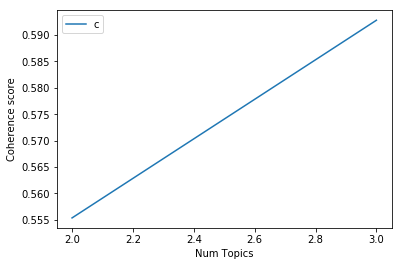

In [44]:
# Show graph
limit=4; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [45]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 5))

Num Topics = 2  has Coherence Value of 0.55531
Num Topics = 3  has Coherence Value of 0.59283


In [46]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.052*"time" + 0.048*"lecture" + 0.038*"learning" + 0.024*"quiz" + '
  '0.024*"platform" + 0.024*"cover" + 0.019*"concept" + 0.019*"feel" + '
  '0.019*"attempt" + 0.019*"lack"'),
 (1,
  '0.088*"video" + 0.064*"assignment" + 0.059*"material" + 0.049*"learn" + '
  '0.049*"work" + 0.039*"question" + 0.020*"download" + 0.020*"provide" + '
  '0.020*"complete" + 0.015*"bit"'),
 (2,
  '0.042*"poor" + 0.042*"content" + 0.037*"good" + 0.032*"answer" + '
  '0.021*"support" + 0.016*"practical" + 0.016*"system" + 0.016*"explain" + '
  '0.016*"machine" + 0.016*"python"')]


In [47]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
print(len(df_dominant_topic))
df_dominant_topic.head(10)

68


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.3539,"poor, content, good, answer, support, practica...",Too costly for the same content available at v...
1,1,1.0,0.3522,"video, assignment, material, learn, work, ques...",Need more time to complete all assignments
2,2,1.0,0.3519,"video, assignment, material, learn, work, ques...",it is too pricy for a beginner course compared...
3,3,2.0,0.3559,"poor, content, good, answer, support, practica...","Terrible user experience, poor video lessons, ..."
4,4,2.0,0.4170,"poor, content, good, answer, support, practica...",Poor presentations from content to the way the...
5,5,2.0,0.3508,"poor, content, good, answer, support, practica...",There was a lack of fit between the lectures a...
6,6,0.0,0.3522,"time, lecture, learning, quiz, platform, cover...",This course has a unique way of teaching conce...
7,7,2.0,0.3495,"poor, content, good, answer, support, practica...",I may not recommended due to lack of the integ...
8,8,0.0,0.3979,"time, lecture, learning, quiz, platform, cover...",Although its an applied course it attempts to ...
9,9,1.0,0.3832,"video, assignment, material, learn, work, ques...",You tried to cover way too much material in to...


In [48]:
print(len(df_topic_sents_keywords))
df_topic_sents_keywords.head(10)

68


,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,2.0,0.3539,"poor, content, good, answer, support, practica...",Too costly for the same content available at v...
1,1.0,0.3522,"video, assignment, material, learn, work, ques...",Need more time to complete all assignments
2,1.0,0.3519,"video, assignment, material, learn, work, ques...",it is too pricy for a beginner course compared...
3,2.0,0.3559,"poor, content, good, answer, support, practica...","Terrible user experience, poor video lessons, ..."
4,2.0,0.4170,"poor, content, good, answer, support, practica...",Poor presentations from content to the way the...
5,2.0,0.3508,"poor, content, good, answer, support, practica...",There was a lack of fit between the lectures a...
6,0.0,0.3522,"time, lecture, learning, quiz, platform, cover...",This course has a unique way of teaching conce...
7,2.0,0.3495,"poor, content, good, answer, support, practica...",I may not recommended due to lack of the integ...
8,0.0,0.3979,"time, lecture, learning, quiz, platform, cover...",Although its an applied course it attempts to ...
9,1.0,0.3832,"video, assignment, material, learn, work, ques...",You tried to cover way too much material in to...


In [49]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
print(len(sent_topics_sorteddf_mallet))
sent_topics_sorteddf_mallet

3


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3979,"time, lecture, learning, quiz, platform, cover...",Although its an applied course it attempts to ...
1,1.0,0.4138,"video, assignment, material, learn, work, ques...",The course is not very well organized. Videos ...
2,2.0,0.4170,"poor, content, good, answer, support, practica...",Poor presentations from content to the way the...


In [50]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([sent_topics_sorteddf_mallet, topic_counts, topic_contribution], axis=1)
del df_dominant_topics['Topic_Perc_Contrib']
# Change Column names
df_dominant_topics.columns = ['Topic_Num', 'Topic_Keywords', 'Text Sample from Data', 'Num_Documents', 'Perc_Documents']

# Show

df_dominant_topics = df_dominant_topics[:3]
df_dominant_topics

,Topic_Num,Topic_Keywords,Text Sample from Data,Num_Documents,Perc_Documents
0,0.0,"time, lecture, learning, quiz, platform, cover...",Although its an applied course it attempts to ...,28,0.4118
1,1.0,"video, assignment, material, learn, work, ques...",The course is not very well organized. Videos ...,21,0.3088
2,2.0,"poor, content, good, answer, support, practica...",Poor presentations from content to the way the...,19,0.2794


In [0]:
#converting to csv
df_dominant_topics.to_csv('topic_distribution_3.csv', index=False)
df_dominant_topic.to_csv('document_dsitribution_3.csv', index=False)

In [0]:
'''from google.colab import files
files.download('topic_distribution.csv')
files.download('document_dsitribution.csv')'''

In [0]:
#converting to csv to drive
df_dominant_topics.to_csv('/gdrive/My Drive/topic_distribution_3.csv', index=False)
df_dominant_topic.to_csv('/gdrive/My Drive/document_dsitribution_3.csv', index=False)